# WICHTIG: Bitte lesen Sie zuerst die README

# Welding Defect Detection with YOLOv8

Dieses Projekt beschäftigt sich mit der automatisierten Erkennung von Schweißnahtfehlern anhand von Bilddaten. Ziel ist es, mithilfe des YOLOv8-Modells (You Only Look Once) fehlerhafte Schweißnähte zu erkennen, zu klassifizieren und visuell darzustellen. Dabei wird ein typischer Machine-Learning-Workflow verfolgt, der von der Datenexploration über das Training bis zur Evaluation und Visualisierung reicht.

## Ziel des Projekts

Das Hauptziel ist die Entwicklung eines robusten Bildklassifikationsmodells zur Detektion und Kategorisierung von Schweißnahtfehlern. Dazu werden folgende Teilziele verfolgt:

* Explorative Datenanalyse (EDA), um Einblick in die Datenstruktur und -verteilung zu gewinnen.
* Training eines YOLOv8-Modells auf einem gelabelten Datensatz mit verschiedenen Fehlerklassen.
* Analyse und Visualisierung der Trainingsmetriken zur Bewertung der Modellgüte.
* Anwendung des trainierten Modells auf Testbilder zur Demonstration der Praxistauglichkeit.

## Projektablauf

### 1. Datenexploration

* Zufällige Bildvorschau aus dem Trainingsdatensatz mithilfe von OpenCV.
* Überblick über die Anzahl an Bildern in den Datensatz-Splits (`train`, `valid`, `test`).
* Analyse der Labeldateien im YOLO-Format, um die Häufigkeit der Klassen zu ermitteln.

### 2. Explorative Datenanalyse (EDA)

* Erstellung von Balkendiagrammen zur Veranschaulichung der Bildverteilung in den einzelnen Datensplits.
* Visualisierung der Klassenverteilung innerhalb des Trainingssets mittels Seaborn.

### 3. Modelltraining

* Verwendung eines vortrainierten YOLOv8m-Modells als Ausgangspunkt.
* Feinjustierung der Hyperparameter (Batch Size, Learning Rate, Augmentationen etc.).
* Training über 100 Epochen mit automatischer Namensvergabe für jedes Training.

### 4. Evaluation

* Laden und Parsen der `results.csv` zur Analyse der Trainingsmetriken:

  * Precision
  * Recall
  * mAP\@0.5
  * mAP\@0.5:0.95
* Visualisierung dieser Metriken über den Trainingsverlauf hinweg.
* Hervorhebung der besten Ergebnisse im Plot.

### 5. Modellanwendung

* Auswahl von 15 zufälligen Bildern aus dem Testset.
* Anwendung des trainierten Modells und Visualisierung der Vorhersagen.

## Ergebnisse & Nutzen

* Nach erfolgreichem Training liefert das Modell visuelle und statistische Hinweise auf erkannte Fehler.
* Der Workflow ist automatisiert und kann für neue Datensätze leicht angepasst werden.
* Die Projektstruktur ist reproduzierbar und modular aufgebaut.

## Visuelle Modellbewertung

* 15 zufällig gewählte Bilder aus dem Testdatensatz.
* Modellvorhersagen werden visualisiert und gespeichert unter `runs/detect/exp_<timestamp>`.


In [1]:
!pip install ultralytics

In [2]:
import os
import re
import random, time
from dotenv import load_dotenv

import matplotlib.pyplot as plt
import cv2
from IPython.display import Image, display
import pandas as pd
import seaborn as sns
from ultralytics import YOLO


In [3]:
load_dotenv()

root_dir_data = os.environ['ROOT_DIR_DATA']
root_dir_runs_detect = os.environ['ROOT_DIR_RUNS_DETECT']

v2_dir = os.path.join(root_dir_data, 'The Welding Defect Dataset')
yaml_dir = os.path.join(v2_dir, 'data.yaml')


# **Data exploration and example visualization:**

Displaying some welding images from the training dataset:


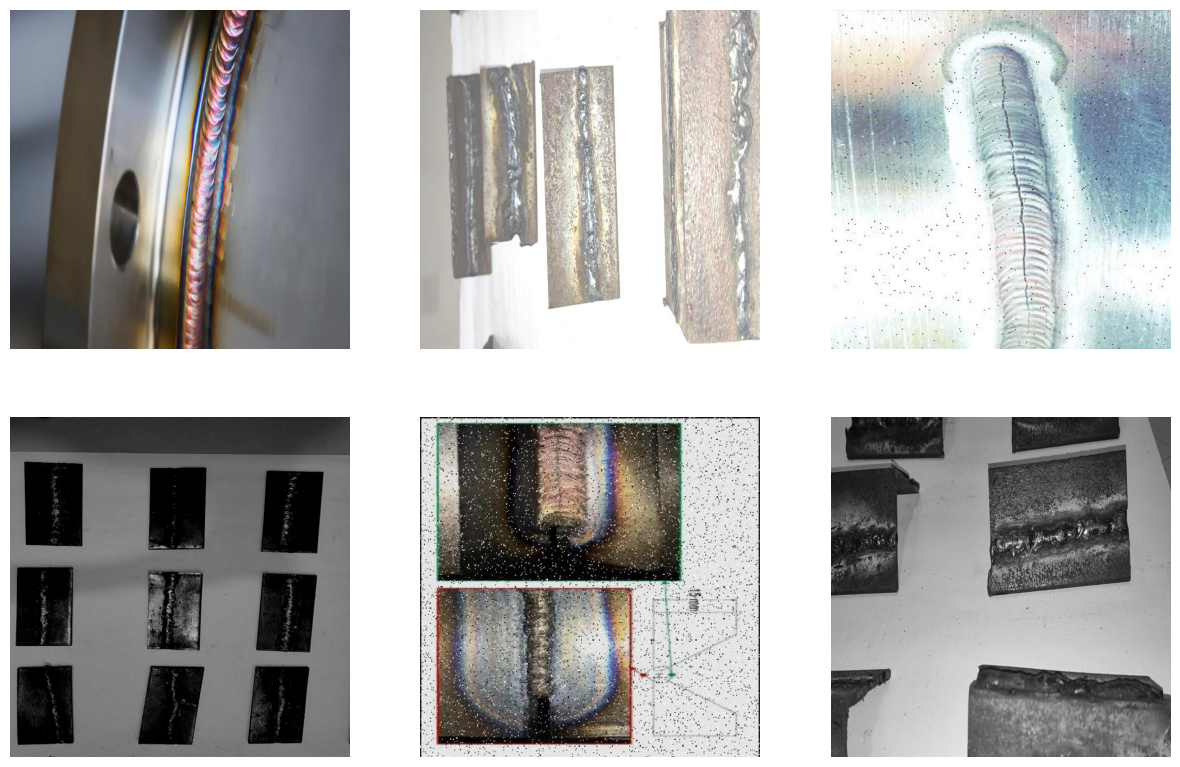

In [4]:
def display_images(image_dir, num_images=6):
    
    random.seed(time.time())
    images = os.listdir(image_dir)
    sample_images = random.sample(images, num_images)
    
    plt.figure(figsize=(15, 15))
    
    for i, image_name in enumerate(sample_images):
        
        image_path = os.path.join(image_dir, image_name)
        img = cv2.imread(image_path)
        
        # OpenCV loads the image in BGR format by default (blueish instead of natural colors).
        # This is due to historical and performance reasons: many camera sensors and industrial interfaces 
        # (e.g., USB Vision, GigE Vision) provide image data in BGR or Grayscale format.
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        plt.subplot(3, 3, i + 1)
        plt.imshow(img_rgb)
        plt.axis('off')
        
    plt.show()

print("Displaying some welding images from the training dataset:")
display_images(os.path.join(v2_dir, 'train/images'))


# **EDA - Exploratory Data Analysis:**


Number of images in training set: 839
Number of images in valid set: 176
Number of images in test set: 74
Total number of images: 1089



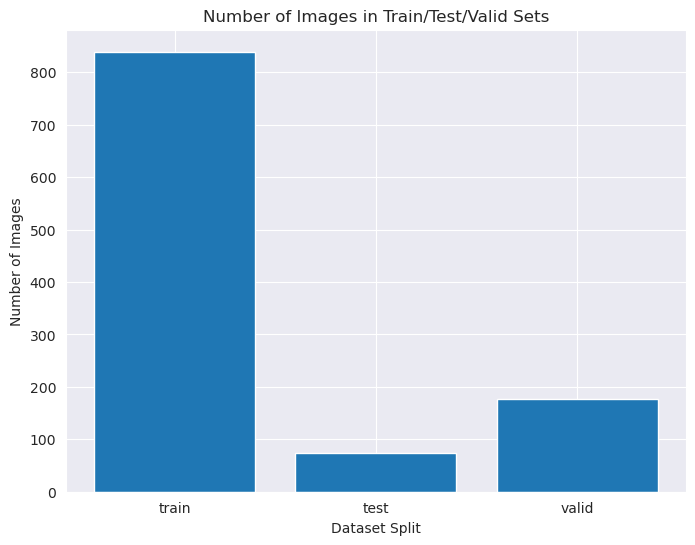


(3145, 6)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3145 entries, 0 to 3144
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   file      3145 non-null   object 
 1   class_id  3145 non-null   float64
 2   x_center  3145 non-null   float64
 3   y_center  3145 non-null   float64
 4   width     3145 non-null   float64
 5   height    3145 non-null   float64
dtypes: float64(5), object(1)
memory usage: 147.6+ KB
None



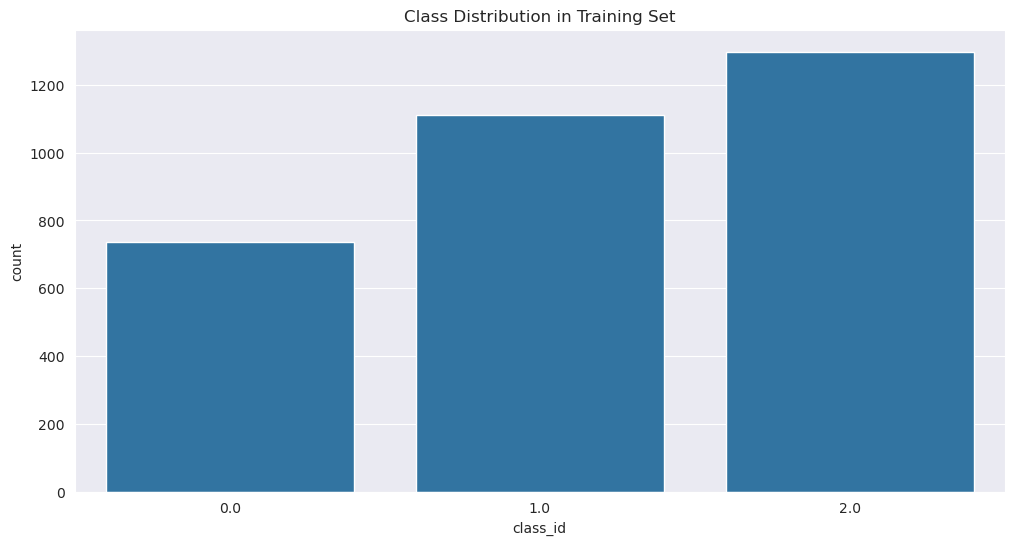


Class counts:
 class_id
0.0     736
1.0    1111
2.0    1298
Name: count, dtype: int64
Max count per class: 1298


In [5]:
def count_pictures(root_dir):
    
    train = os.listdir(os.path.join(root_dir, 'train/images'))
    test = os.listdir(os.path.join(root_dir, 'test/images'))
    valid = os.listdir(os.path.join(root_dir, 'valid/images'))
    
    count_train_pict = len(train)
    count_test_pict = len(test)
    count_valid_pict = len(valid)
    
    sum_pict = count_train_pict + count_test_pict + count_valid_pict
    
    print()
    print(f'Number of images in training set: {count_train_pict}')
    print(f'Number of images in valid set: {count_valid_pict}')
    print(f'Number of images in test set: {count_test_pict}')
    print(f'Total number of images: {sum_pict}')
    print()
    
    splits = ['train', 'test', 'valid']
    counts = [count_train_pict, count_test_pict, count_valid_pict]

    plt.figure(figsize=(8, 6))
    plt.bar(splits, counts)
    plt.title('Number of Images in Train/Test/Valid Sets')
    plt.ylabel('Number of Images')
    plt.xlabel('Dataset Split')
    plt.show()


def load_labels(label_dir):
    
    label_files = os.listdir(label_dir)
    data = []
    
    for label_file in label_files:
        
        with open(os.path.join(label_dir, label_file), 'r') as file:    
            lines = file.readlines()
            
            for line in lines:
                class_id, x_center, y_center, width, height = map(float, line.strip().split())
                data.append([label_file, class_id, x_center, y_center, width, height])
                
    df = pd.DataFrame(data, columns=['file', 'class_id', 'x_center', 'y_center', 'width', 'height'])
    
    return df

count_pictures(v2_dir)

train_labels_df = load_labels(os.path.join(v2_dir, 'train/labels'))

print()
print(train_labels_df.shape)
print(train_labels_df.info())
print()

plt.figure(figsize=(12, 6))
sns.countplot(data=train_labels_df, x='class_id')
plt.title('Class Distribution in Training Set')
plt.show()

class_counts = train_labels_df['class_id'].value_counts().sort_index()
max_count = class_counts.max()
print("\nClass counts:\n", class_counts)
print("Max count per class:", max_count)


# *Model Training:*

In [6]:
model = YOLO('yolov8m.pt')

In [7]:
runs = os.listdir(root_dir_runs_detect)
set_seed = 42 # to keep experiments reproducible

if len(runs) == 0:
    value = 0

else:
    value = len(runs)
    
model_name = f'welding_v2_aug_'

model.train(
    
    data=yaml_dir, epochs=100, imgsz=640, batch=16, name=f'{model_name}{value}', patience=10, lr0=0.005, momentum=0.937, 
    weight_decay=0.0005, warmup_epochs=10.0, warmup_momentum=0.9, warmup_bias_lr=0.1, box=0.05, cls=0.7, iou=0.3, 
    hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, translate=0.1, scale=0.5, mosaic=0.5, mixup=0.2, seed=set_seed
    
)

New https://pypi.org/project/ultralytics/8.3.152 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.146 🚀 Python-3.12.7 torch-2.7.0+cu126 CUDA:0 (NVIDIA GeForce RTX 4070 Laptop GPU, 7721MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=0.05, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.7, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/home/roman/PycharmProjects/scientificProject_weldingFailerDetection_BlaasRoman/data/The Welding Defect Dataset/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.3, keras=False, kobj=1.0, line_width=None, lr0=0.005, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.2, mode=train, m

train: Scanning /home/roman/PycharmProjects/scientificProject_weldingFailerDetection_BlaasRoman/data/The Welding Defect Dataset/train/labels.cache... 839 images, 0 backgrounds, 0 corrupt: 100%|██████████| 839/839 [00:00<?, ?it/s]


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2466.1±1448.6 MB/s, size: 51.6 KB)


val: Scanning /home/roman/PycharmProjects/scientificProject_weldingFailerDetection_BlaasRoman/data/The Welding Defect Dataset/valid/labels.cache... 176 images, 0 backgrounds, 0 corrupt: 100%|██████████| 176/176 [00:00<?, ?it/s]


Plotting labels to runs/detect/welding_v2_aug_0/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.005' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001429, momentum=0.9) with parameter groups 77 weight(decay=0.0), 84 weight(decay=0.0005), 83 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/detect/welding_v2_aug_0
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100       6.2G    0.01443      4.505      1.891         47        640: 100%|██████████| 53/53 [00:19<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.72it/s]

                   all        176        573      0.304      0.417      0.305      0.146



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      6.31G    0.01268      3.277      1.639         44        640: 100%|██████████| 53/53 [00:18<00:00,  2.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.98it/s]

                   all        176        573      0.364      0.497      0.304      0.129



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      6.49G    0.01297      3.151       1.71         33        640: 100%|██████████| 53/53 [00:18<00:00,  2.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.69it/s]

                   all        176        573      0.284      0.466      0.267      0.124



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      6.26G     0.0133      3.162      1.735         42        640: 100%|██████████| 53/53 [00:18<00:00,  2.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.92it/s]

                   all        176        573      0.322      0.407      0.297      0.134



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      6.49G    0.01365      3.175      1.765         29        640: 100%|██████████| 53/53 [00:18<00:00,  2.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.60it/s]

                   all        176        573      0.315       0.38      0.245     0.0971



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      6.31G    0.01352      3.083      1.763         41        640: 100%|██████████| 53/53 [00:18<00:00,  2.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.88it/s]

                   all        176        573      0.347       0.43      0.263     0.0951



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      6.28G    0.01346      3.109      1.777         39        640: 100%|██████████| 53/53 [00:18<00:00,  2.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.91it/s]

                   all        176        573      0.357      0.453      0.329      0.153



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      6.45G    0.01342      3.127      1.801         35        640: 100%|██████████| 53/53 [00:18<00:00,  2.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.59it/s]

                   all        176        573      0.272       0.36      0.212     0.0876



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      6.24G    0.01322      3.058      1.756         28        640: 100%|██████████| 53/53 [00:18<00:00,  2.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.87it/s]

                   all        176        573      0.385      0.464      0.362      0.159



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      6.28G      0.013      3.018      1.754         43        640: 100%|██████████| 53/53 [00:18<00:00,  2.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.87it/s]

                   all        176        573      0.388      0.393      0.299      0.129



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      6.36G    0.01294      2.959      1.734         21        640: 100%|██████████| 53/53 [00:18<00:00,  2.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.69it/s]

                   all        176        573      0.396      0.467      0.383      0.173



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      6.42G     0.0129      2.929      1.749         79        640: 100%|██████████| 53/53 [00:18<00:00,  2.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.83it/s]

                   all        176        573      0.376      0.423      0.327      0.146



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      6.47G    0.01253      2.794      1.668         43        640: 100%|██████████| 53/53 [00:18<00:00,  2.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.92it/s]

                   all        176        573      0.409       0.47      0.384      0.178



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      6.43G    0.01258      2.815      1.705         12        640: 100%|██████████| 53/53 [00:18<00:00,  2.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.66it/s]

                   all        176        573       0.42      0.495       0.37       0.16



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100       6.3G    0.01242      2.781      1.671         55        640: 100%|██████████| 53/53 [00:18<00:00,  2.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.97it/s]

                   all        176        573      0.377      0.513      0.374      0.173



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      6.46G    0.01222      2.692      1.654         76        640: 100%|██████████| 53/53 [00:18<00:00,  2.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.77it/s]

                   all        176        573      0.462      0.455      0.385      0.187



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      6.33G    0.01203      2.621      1.628         46        640: 100%|██████████| 53/53 [00:18<00:00,  2.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.94it/s]

                   all        176        573      0.419      0.551       0.43      0.203



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      6.49G    0.01194      2.596      1.605         69        640: 100%|██████████| 53/53 [00:18<00:00,  2.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.92it/s]

                   all        176        573      0.415      0.552      0.422      0.206



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      6.33G    0.01202      2.612      1.617         52        640: 100%|██████████| 53/53 [00:18<00:00,  2.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.72it/s]

                   all        176        573      0.488       0.51      0.452      0.207



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      6.31G    0.01182       2.54      1.602         38        640: 100%|██████████| 53/53 [00:18<00:00,  2.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.89it/s]

                   all        176        573      0.411      0.522      0.411      0.191



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      6.46G    0.01197      2.579      1.621         31        640: 100%|██████████| 53/53 [00:18<00:00,  2.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.90it/s]

                   all        176        573      0.482      0.571      0.475      0.227



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      6.44G    0.01181      2.532      1.593         42        640: 100%|██████████| 53/53 [00:18<00:00,  2.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.68it/s]

                   all        176        573      0.436      0.533      0.407      0.205



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      6.26G    0.01169      2.507      1.602         39        640: 100%|██████████| 53/53 [00:18<00:00,  2.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.96it/s]

                   all        176        573      0.506      0.522      0.477      0.238



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      6.43G    0.01158      2.426      1.585         53        640: 100%|██████████| 53/53 [00:18<00:00,  2.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.76it/s]

                   all        176        573      0.506      0.534      0.485      0.238



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      6.29G     0.0114      2.373      1.561         43        640: 100%|██████████| 53/53 [00:18<00:00,  2.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.95it/s]

                   all        176        573       0.49      0.571      0.503      0.257



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      6.48G    0.01127      2.356      1.553         72        640: 100%|██████████| 53/53 [00:18<00:00,  2.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.64it/s]

                   all        176        573      0.452      0.526      0.424      0.212



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      6.23G    0.01126       2.33      1.543         48        640: 100%|██████████| 53/53 [00:18<00:00,  2.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.98it/s]

                   all        176        573      0.487      0.588      0.486      0.248



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      6.44G    0.01108      2.309      1.553         50        640: 100%|██████████| 53/53 [00:18<00:00,  2.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.74it/s]

                   all        176        573      0.465      0.538      0.466      0.239



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      6.37G    0.01104       2.25      1.524         46        640: 100%|██████████| 53/53 [00:18<00:00,  2.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.96it/s]

                   all        176        573      0.514      0.584      0.491      0.247



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      6.41G    0.01099      2.249      1.539         32        640: 100%|██████████| 53/53 [00:18<00:00,  2.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.98it/s]

                   all        176        573      0.547      0.597      0.525      0.284



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      6.32G    0.01078      2.168      1.504         70        640: 100%|██████████| 53/53 [00:18<00:00,  2.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.76it/s]

                   all        176        573      0.431      0.551      0.463      0.248



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      6.36G    0.01069      2.211      1.512         27        640: 100%|██████████| 53/53 [00:18<00:00,  2.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.97it/s]

                   all        176        573      0.526      0.608      0.503      0.264



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      6.44G     0.0107      2.093      1.497         33        640: 100%|██████████| 53/53 [00:18<00:00,  2.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.96it/s]

                   all        176        573      0.608      0.541      0.555      0.289



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      6.44G    0.01063      2.145      1.494         46        640: 100%|██████████| 53/53 [00:18<00:00,  2.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.74it/s]

                   all        176        573      0.553      0.586      0.556      0.294



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      6.31G    0.01052      2.097      1.477         54        640: 100%|██████████| 53/53 [00:18<00:00,  2.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.97it/s]

                   all        176        573      0.546      0.552      0.497      0.269



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100       6.5G    0.01039      2.093       1.49         29        640: 100%|██████████| 53/53 [00:18<00:00,  2.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.76it/s]

                   all        176        573      0.551      0.613      0.556      0.292



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100       6.4G    0.01036       2.02      1.463         25        640: 100%|██████████| 53/53 [00:18<00:00,  2.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.96it/s]

                   all        176        573      0.547      0.573      0.521      0.261



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      6.44G    0.01035      2.021      1.468         56        640: 100%|██████████| 53/53 [00:18<00:00,  2.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.94it/s]

                   all        176        573      0.561      0.613      0.551      0.292



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      6.33G    0.01035      1.976       1.45         32        640: 100%|██████████| 53/53 [00:18<00:00,  2.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.72it/s]

                   all        176        573       0.57      0.591      0.553      0.311



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      6.31G    0.01021      1.949      1.452         59        640: 100%|██████████| 53/53 [00:18<00:00,  2.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.92it/s]

                   all        176        573      0.577      0.587      0.552      0.298



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      6.48G    0.01017      1.923      1.439         31        640: 100%|██████████| 53/53 [00:18<00:00,  2.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.88it/s]

                   all        176        573      0.559      0.605      0.567      0.305



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      6.38G    0.01029      1.937      1.445         62        640: 100%|██████████| 53/53 [00:18<00:00,  2.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.67it/s]

                   all        176        573      0.517      0.649      0.576      0.318



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      6.23G    0.01008      1.881      1.433         40        640: 100%|██████████| 53/53 [00:18<00:00,  2.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.89it/s]

                   all        176        573       0.61      0.572      0.579      0.323



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      6.54G    0.01008      1.873      1.442         32        640: 100%|██████████| 53/53 [00:18<00:00,  2.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.70it/s]

                   all        176        573      0.605       0.59      0.581      0.313



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      6.29G    0.01004      1.841      1.433         27        640: 100%|██████████| 53/53 [00:18<00:00,  2.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.87it/s]

                   all        176        573      0.574      0.591      0.572      0.305



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      6.44G       0.01      1.852      1.429         34        640: 100%|██████████| 53/53 [00:18<00:00,  2.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.92it/s]

                   all        176        573      0.568      0.608      0.571      0.301



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      6.29G   0.009892      1.837      1.431         34        640: 100%|██████████| 53/53 [00:18<00:00,  2.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.74it/s]

                   all        176        573      0.564      0.585      0.561      0.302



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      6.36G   0.009829      1.786      1.398         36        640: 100%|██████████| 53/53 [00:18<00:00,  2.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.92it/s]

                   all        176        573      0.589      0.607      0.565      0.319



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      6.48G   0.009798      1.815      1.406         52        640: 100%|██████████| 53/53 [00:18<00:00,  2.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.97it/s]

                   all        176        573      0.586      0.619      0.603      0.334



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      6.45G   0.009604      1.752        1.4         55        640: 100%|██████████| 53/53 [00:18<00:00,  2.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.72it/s]

                   all        176        573      0.637      0.567      0.602      0.322



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      6.24G   0.009611      1.743      1.405         32        640: 100%|██████████| 53/53 [00:18<00:00,  2.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.98it/s]

                   all        176        573      0.651      0.598       0.62      0.335



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      6.54G   0.009861      1.753      1.407         43        640: 100%|██████████| 53/53 [00:18<00:00,  2.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.72it/s]

                   all        176        573      0.663      0.588      0.612       0.33



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      6.32G   0.009661      1.713      1.392         39        640: 100%|██████████| 53/53 [00:18<00:00,  2.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.92it/s]

                   all        176        573      0.612      0.591      0.585      0.322



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      6.45G   0.009615      1.717      1.375         43        640: 100%|██████████| 53/53 [00:18<00:00,  2.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.99it/s]

                   all        176        573      0.652      0.578      0.592      0.332



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      6.37G   0.009557      1.681      1.378         62        640: 100%|██████████| 53/53 [00:18<00:00,  2.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.76it/s]

                   all        176        573      0.601      0.585      0.597      0.322



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100      6.37G   0.009451      1.681      1.369         32        640: 100%|██████████| 53/53 [00:18<00:00,  2.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.00it/s]

                   all        176        573      0.556      0.642       0.59      0.337



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      6.51G   0.009401      1.641      1.362         37        640: 100%|██████████| 53/53 [00:18<00:00,  2.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.76it/s]

                   all        176        573      0.637      0.602      0.611      0.343



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100      6.33G   0.009404      1.638      1.377         33        640: 100%|██████████| 53/53 [00:18<00:00,  2.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.00it/s]

                   all        176        573       0.59      0.647       0.59      0.342



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      6.36G   0.009399      1.614      1.366         43        640: 100%|██████████| 53/53 [00:18<00:00,  2.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.79it/s]

                   all        176        573       0.61      0.623      0.617      0.346



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      6.36G   0.009234      1.599      1.341         54        640: 100%|██████████| 53/53 [00:18<00:00,  2.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.91it/s]

                   all        176        573      0.622      0.609      0.595      0.338



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100      6.45G   0.009021      1.531      1.336         31        640: 100%|██████████| 53/53 [00:18<00:00,  2.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.02it/s]

                   all        176        573      0.627      0.625      0.628      0.352



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100      6.41G   0.009104      1.528      1.324         32        640: 100%|██████████| 53/53 [00:18<00:00,  2.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.78it/s]

                   all        176        573      0.675      0.572      0.617      0.356



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      6.27G   0.009051      1.518      1.336         54        640: 100%|██████████| 53/53 [00:18<00:00,  2.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.03it/s]

                   all        176        573      0.656      0.593      0.615      0.345



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100      6.49G   0.009022      1.499      1.336         43        640: 100%|██████████| 53/53 [00:18<00:00,  2.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.77it/s]

                   all        176        573      0.663      0.598      0.634      0.364



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100      6.41G   0.008919       1.48      1.327         22        640: 100%|██████████| 53/53 [00:18<00:00,  2.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.97it/s]

                   all        176        573      0.621      0.639      0.633      0.351



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100      6.52G   0.008844      1.484      1.316         38        640: 100%|██████████| 53/53 [00:18<00:00,  2.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.70it/s]

                   all        176        573      0.634      0.664      0.634      0.357



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100      6.24G   0.008878      1.481       1.33         39        640: 100%|██████████| 53/53 [00:18<00:00,  2.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.01it/s]

                   all        176        573       0.62      0.631      0.614      0.354



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100      6.46G   0.008855      1.464      1.327         47        640: 100%|██████████| 53/53 [00:18<00:00,  2.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.80it/s]

                   all        176        573       0.65       0.65      0.655      0.376



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100      6.37G   0.008729      1.464      1.309         51        640: 100%|██████████| 53/53 [00:18<00:00,  2.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.93it/s]

                   all        176        573      0.626      0.653      0.627      0.368



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100      6.41G   0.008755       1.43      1.296         42        640: 100%|██████████| 53/53 [00:18<00:00,  2.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.72it/s]

                   all        176        573      0.627      0.626      0.625      0.356



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100      6.31G   0.008786      1.469      1.309         31        640: 100%|██████████| 53/53 [00:18<00:00,  2.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.92it/s]

                   all        176        573      0.613      0.626      0.598      0.346



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100      6.51G   0.008616      1.407      1.294         41        640: 100%|██████████| 53/53 [00:18<00:00,  2.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.78it/s]

                   all        176        573      0.625      0.652      0.643      0.367



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100      6.37G    0.00857      1.408      1.294         50        640: 100%|██████████| 53/53 [00:18<00:00,  2.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.02it/s]

                   all        176        573      0.635       0.64      0.629       0.36



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100      6.47G   0.008442      1.414      1.302         43        640: 100%|██████████| 53/53 [00:18<00:00,  2.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.00it/s]

                   all        176        573      0.659      0.614      0.623      0.349



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100       6.3G   0.008578      1.411      1.282         38        640: 100%|██████████| 53/53 [00:18<00:00,  2.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.77it/s]

                   all        176        573      0.647      0.651      0.644       0.37



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100      6.34G   0.008474      1.362      1.285         53        640: 100%|██████████| 53/53 [00:18<00:00,  2.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.01it/s]

                   all        176        573      0.633      0.659      0.637      0.358



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100      6.42G   0.008442      1.391      1.287         26        640: 100%|██████████| 53/53 [00:18<00:00,  2.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.03it/s]

                   all        176        573      0.669      0.662      0.653      0.381



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100      6.44G   0.008491      1.377      1.279         58        640: 100%|██████████| 53/53 [00:18<00:00,  2.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.78it/s]

                   all        176        573       0.66      0.634      0.634      0.364



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100      6.28G   0.008147      1.284      1.247         26        640: 100%|██████████| 53/53 [00:18<00:00,  2.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.01it/s]

                   all        176        573      0.633       0.65      0.635      0.364



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100      6.47G   0.008201      1.301      1.264         19        640: 100%|██████████| 53/53 [00:18<00:00,  2.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.79it/s]

                   all        176        573      0.652      0.645      0.647      0.374



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100      6.36G   0.008279      1.322      1.261         45        640: 100%|██████████| 53/53 [00:18<00:00,  2.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.00it/s]

                   all        176        573      0.645      0.642      0.641      0.365



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100      6.46G   0.008138      1.315      1.255         23        640: 100%|██████████| 53/53 [00:18<00:00,  2.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.00it/s]

                   all        176        573       0.63      0.635       0.64      0.369



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100       6.4G   0.008023      1.246      1.232         51        640: 100%|██████████| 53/53 [00:18<00:00,  2.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.77it/s]

                   all        176        573      0.587      0.662      0.636      0.372



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100      6.34G   0.007983       1.25      1.234         24        640: 100%|██████████| 53/53 [00:18<00:00,  2.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.01it/s]

                   all        176        573      0.649      0.671      0.657      0.386



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100       6.5G   0.008019      1.262       1.25         40        640: 100%|██████████| 53/53 [00:18<00:00,  2.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.04it/s]

                   all        176        573      0.596      0.696      0.639      0.382



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100      6.49G   0.007908      1.218      1.227         55        640: 100%|██████████| 53/53 [00:18<00:00,  2.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.75it/s]

                   all        176        573      0.641       0.66      0.645      0.386



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100       6.2G   0.008014      1.256      1.227         45        640: 100%|██████████| 53/53 [00:18<00:00,  2.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.99it/s]

                   all        176        573      0.671      0.635      0.652      0.381



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100      6.44G   0.007972      1.271      1.234         34        640: 100%|██████████| 53/53 [00:18<00:00,  2.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.77it/s]

                   all        176        573      0.631      0.672      0.653      0.378



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100      6.35G   0.007702      1.197      1.202         44        640: 100%|██████████| 53/53 [00:18<00:00,  2.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.00it/s]

                   all        176        573      0.648      0.675      0.653       0.38



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100      6.52G   0.007699      1.159      1.207         50        640: 100%|██████████| 53/53 [00:18<00:00,  2.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.75it/s]

                   all        176        573      0.657      0.663      0.651      0.379


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100      6.21G     0.0067     0.9261      1.136         34        640: 100%|██████████| 53/53 [00:18<00:00,  2.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.01it/s]

                   all        176        573      0.654      0.671       0.65      0.374



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100      6.45G   0.006535     0.8901      1.113         21        640: 100%|██████████| 53/53 [00:18<00:00,  2.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.74it/s]

                   all        176        573      0.641      0.675       0.66      0.393



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100      6.31G   0.006391     0.8768      1.108          8        640: 100%|██████████| 53/53 [00:18<00:00,  2.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.02it/s]

                   all        176        573      0.684      0.652      0.664      0.397



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100      6.46G   0.006321     0.8517      1.091         19        640: 100%|██████████| 53/53 [00:18<00:00,  2.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.03it/s]

                   all        176        573      0.688      0.632      0.655      0.383



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100      6.33G   0.006239     0.8358      1.084         28        640: 100%|██████████| 53/53 [00:18<00:00,  2.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.83it/s]

                   all        176        573      0.634      0.669      0.651      0.382



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100      6.31G   0.006334     0.8438      1.092         31        640: 100%|██████████| 53/53 [00:18<00:00,  2.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.02it/s]

                   all        176        573      0.681      0.639       0.65      0.387



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100      6.48G   0.006153     0.8148      1.078         33        640: 100%|██████████| 53/53 [00:18<00:00,  2.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.04it/s]

                   all        176        573      0.679      0.647      0.645      0.385



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100       6.4G   0.006152     0.8188       1.08         24        640: 100%|██████████| 53/53 [00:18<00:00,  2.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.78it/s]

                   all        176        573      0.678      0.649      0.649      0.386



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100      6.22G   0.006053     0.8087      1.079         24        640: 100%|██████████| 53/53 [00:18<00:00,  2.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.05it/s]

                   all        176        573      0.666      0.665      0.649      0.387



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100      6.43G   0.006006      0.799      1.061         25        640: 100%|██████████| 53/53 [00:18<00:00,  2.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.78it/s]

                   all        176        573      0.681      0.661      0.659      0.391



100 epochs completed in 0.575 hours.
Optimizer stripped from runs/detect/welding_v2_aug_0/weights/last.pt, 52.0MB
Optimizer stripped from runs/detect/welding_v2_aug_0/weights/best.pt, 52.0MB

Validating runs/detect/welding_v2_aug_0/weights/best.pt...
Ultralytics 8.3.146 🚀 Python-3.12.7 torch-2.7.0+cu126 CUDA:0 (NVIDIA GeForce RTX 4070 Laptop GPU, 7721MiB)
Model summary (fused): 92 layers, 25,841,497 parameters, 0 gradients, 78.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.85it/s]


                   all        176        573      0.684      0.652      0.664      0.397
                   NOK         87        127      0.672      0.748      0.733      0.478
                    OK        119        253      0.754      0.705      0.754      0.497
                Defect         90        193      0.626      0.503      0.504      0.215
Speed: 0.2ms preprocess, 6.5ms inference, 0.0ms loss, 0.6ms postprocess per image
Results saved to runs/detect/welding_v2_aug_0


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x754c1612c200>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.04

# *Mean of precision; recall; mAP50; mAP50-95 for each epoch → best result equals percentage of 50 pts*

Plot metrics from the current model training: welding_v2_aug_00

CSV columns: ['epoch', 'time', 'train/box_loss', 'train/cls_loss', 'train/dfl_loss', 'metrics/precision(B)', 'metrics/recall(B)', 'metrics/mAP50(B)', 'metrics/mAP50-95(B)', 'val/box_loss', 'val/cls_loss', 'val/dfl_loss', 'lr/pg0', 'lr/pg1', 'lr/pg2']


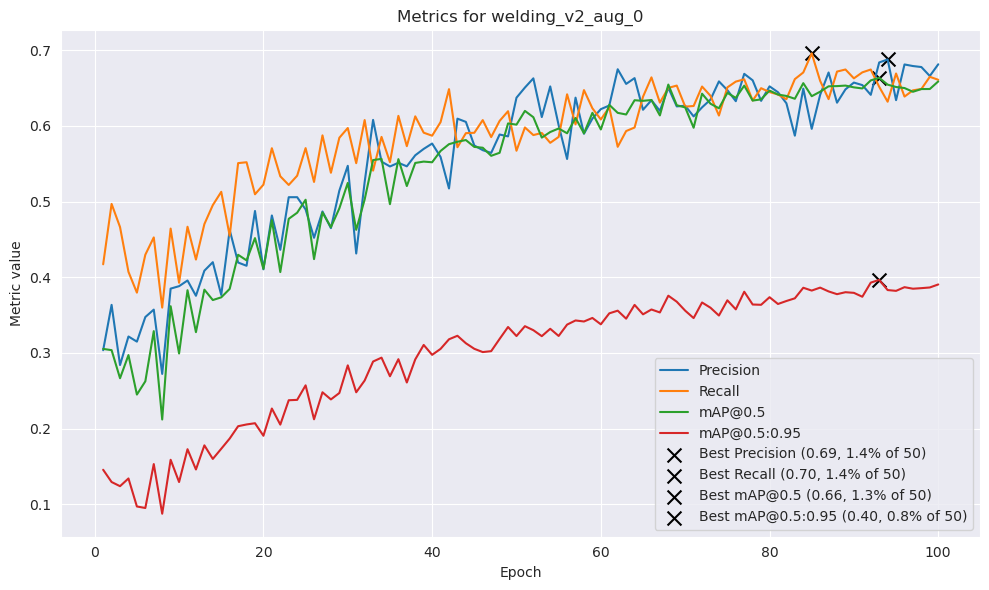

In [8]:
pattern = re.compile(r"welding_v2_aug_(\d+)")

max_value = None
max_file = None

for filename in os.listdir(root_dir_runs_detect):  
    match = pattern.match(filename)
    
    if match:
        value = int(match.group(1))
        
        if max_value is None or value > max_value:
            max_value = value
            max_file = filename
            
if max_file:
    target_file = f'{max_file}{max_value}'
    print(f'Plot metrics from the current model training: {target_file}\n')

    csv_path = os.path.join(root_dir_runs_detect, max_file, "results.csv")

    if not os.path.exists(csv_path):
        print(f'ERROR - No results.csv found at: {csv_path}')
    else:
        df = pd.read_csv(csv_path)
        print("CSV columns:", df.columns.tolist())
  
        precision_col = [col for col in df.columns if "metrics/precision(B)" in col][0]
        recall_col = [col for col in df.columns if "metrics/recall(B)" in col][0]
        map50_col = [col for col in df.columns if "metrics/mAP50(B)" in col][0]
        map5095_col = [col for col in df.columns if "metrics/mAP50-95(B)" in col][0]

        # Plot the progression of the metrics
        plt.figure(figsize=(10, 6))
        plt.plot(df['epoch'], df[precision_col], label="Precision")
        plt.plot(df['epoch'], df[recall_col], label="Recall")
        plt.plot(df['epoch'], df[map50_col], label="mAP@0.5")
        plt.plot(df['epoch'], df[map5095_col], label="mAP@0.5:0.95")

        # Mark best result as a percentage of 50
        for metric, name in [
            (precision_col, "Precision"),
            (recall_col, "Recall"),
            (map50_col, "mAP@0.5"),
            (map5095_col, "mAP@0.5:0.95")
        ]:
            best = df[metric].max()
            percent_of_50 = best * 100 / 50
            plt.scatter(df['epoch'][df[metric].idxmax()], best, label=f"Best {name} ({best:.2f}, {percent_of_50:.1f}% of 50)", 
                        marker='x', s=100, color="black")

        plt.xlabel('Epoch')
        plt.ylabel('Metric value')
        plt.legend()
        plt.title(f'Metrics for {max_file}')
        plt.grid(True)
        plt.tight_layout()
        plt.show()

else:
    print(f'ERROR - No file in target rout path: {root_dir_runs_detect}')
    

# *Evaluate the model with 15 random pictures from the test dataset*


Displaying results from test data


image 1/1 /home/roman/PycharmProjects/scientificProject_weldingFailerDetection_BlaasRoman/data/The Welding Defect Dataset/test/images/1aa4b44c-d01b8a11-Hot-crack_jpg.rf.57393ca7936f061ca5991481b2b5c485.jpg: 640x640 1 Defect, 10.3ms
Speed: 11.5ms preprocess, 10.3ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


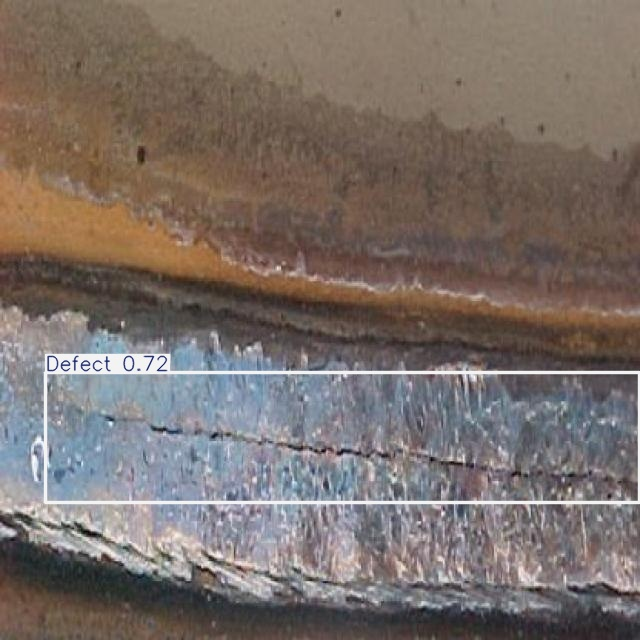


image 1/1 /home/roman/PycharmProjects/scientificProject_weldingFailerDetection_BlaasRoman/data/The Welding Defect Dataset/test/images/poor-Welding-Images_22_jpeg_jpg.rf.3706f7e9a367ae053abfee4902a78288.jpg: 640x640 2 NOKs, 1 OK, 9.8ms
Speed: 0.8ms preprocess, 9.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


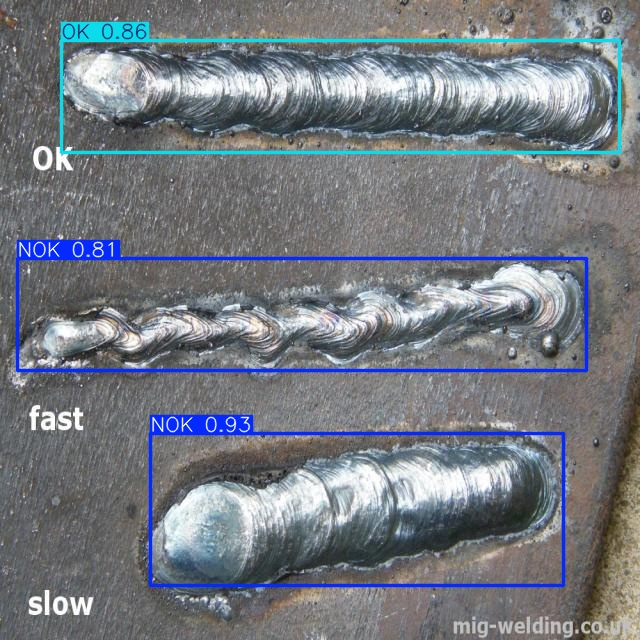


image 1/1 /home/roman/PycharmProjects/scientificProject_weldingFailerDetection_BlaasRoman/data/The Welding Defect Dataset/test/images/SampleV1_1_mp4-42_jpg.rf.6e68d9186e630ffb996233ad2a593f51.jpg: 640x640 2 NOKs, 2 OKs, 3 Defects, 9.8ms
Speed: 1.2ms preprocess, 9.8ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


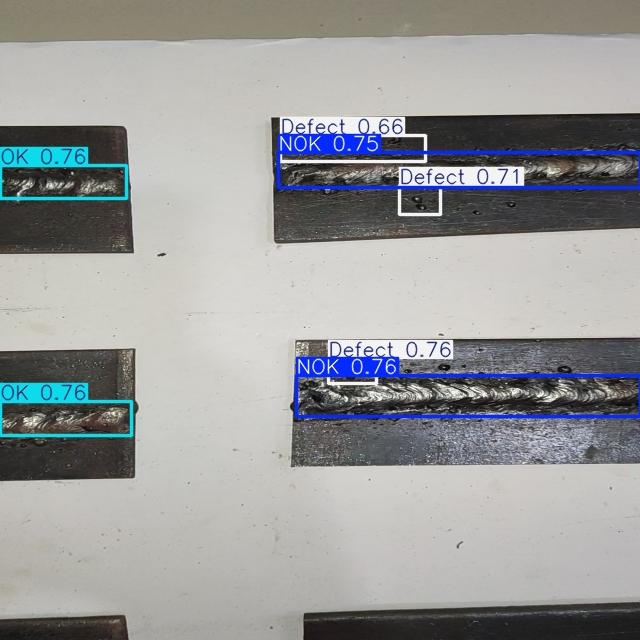


image 1/1 /home/roman/PycharmProjects/scientificProject_weldingFailerDetection_BlaasRoman/data/The Welding Defect Dataset/test/images/good_weld_vid1098_jpeg_jpg.rf.9237cce5d77a8a1c3a6dda6c976ca7d5.jpg: 640x640 (no detections), 9.8ms
Speed: 1.2ms preprocess, 9.8ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


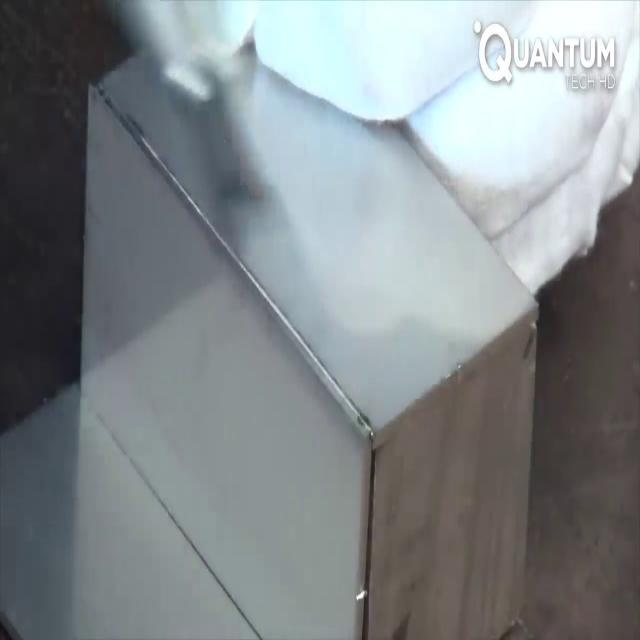


image 1/1 /home/roman/PycharmProjects/scientificProject_weldingFailerDetection_BlaasRoman/data/The Welding Defect Dataset/test/images/Spatters-welding-images_30_jpeg_jpg.rf.ac1f61755f14395f6e5da156c7fd043f.jpg: 640x640 1 NOK, 9.8ms
Speed: 0.9ms preprocess, 9.8ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


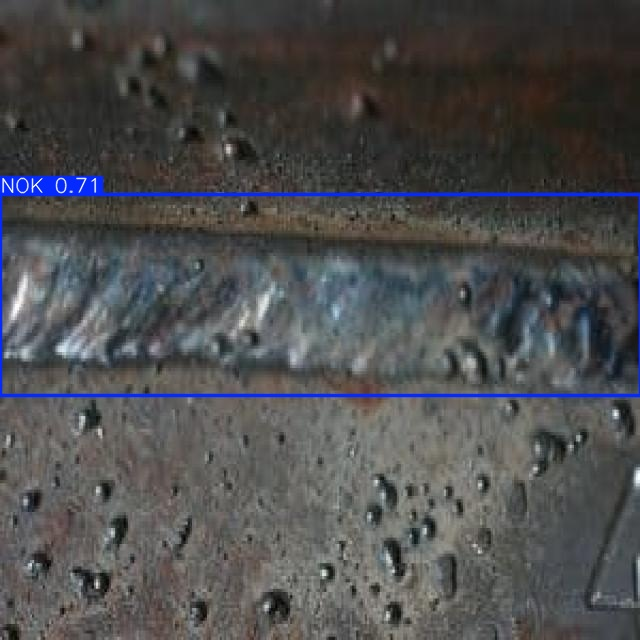


image 1/1 /home/roman/PycharmProjects/scientificProject_weldingFailerDetection_BlaasRoman/data/The Welding Defect Dataset/test/images/Slag-inclusion-welding-images_5_jpeg_jpg.rf.0e134d6e310d401ae657279a12daa898.jpg: 640x640 1 NOK, 9.7ms
Speed: 0.8ms preprocess, 9.7ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


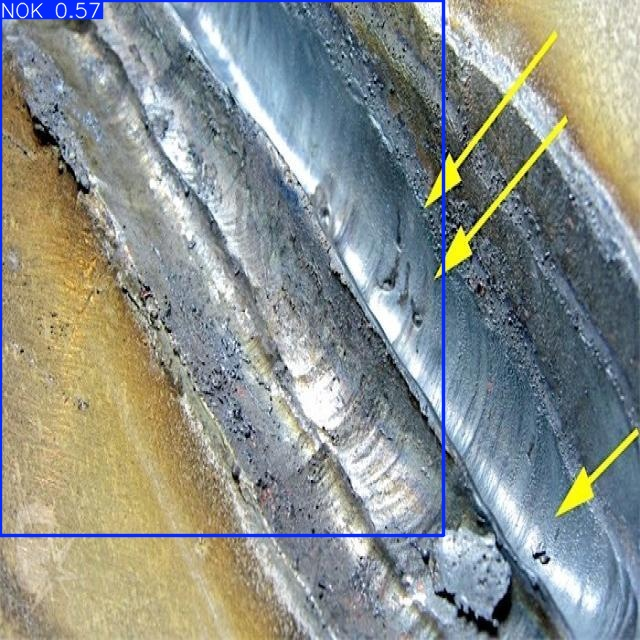


image 1/1 /home/roman/PycharmProjects/scientificProject_weldingFailerDetection_BlaasRoman/data/The Welding Defect Dataset/test/images/good_weld_vid189_jpeg_jpg.rf.33380af68fa3c4f459a81f26d1bdbcb9.jpg: 640x640 1 OK, 9.8ms
Speed: 1.0ms preprocess, 9.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


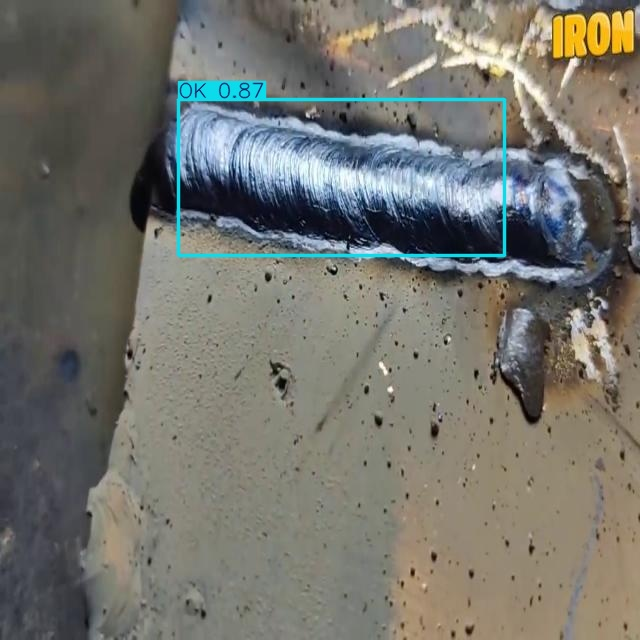


image 1/1 /home/roman/PycharmProjects/scientificProject_weldingFailerDetection_BlaasRoman/data/The Welding Defect Dataset/test/images/Good-Welding-images_33_jpeg_jpg.rf.782ccc0dfca926b946a6b664dd4cacd1.jpg: 640x640 1 OK, 9.9ms
Speed: 1.0ms preprocess, 9.9ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


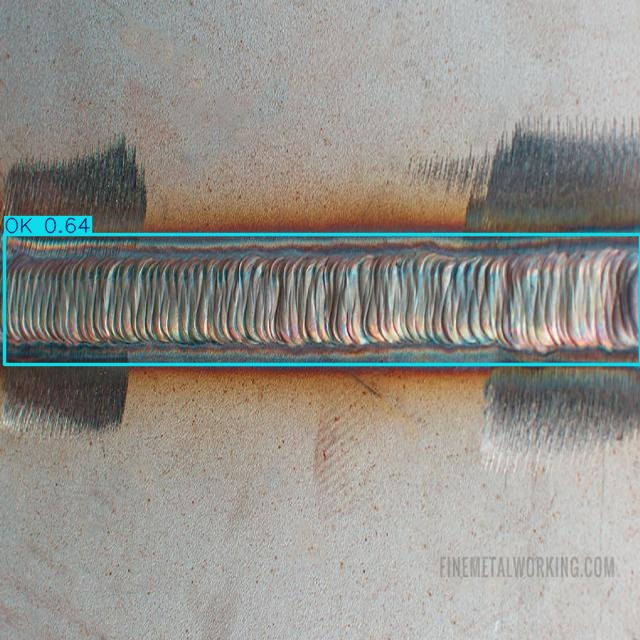


image 1/1 /home/roman/PycharmProjects/scientificProject_weldingFailerDetection_BlaasRoman/data/The Welding Defect Dataset/test/images/SampleV3_1_mp4-8_jpg.rf.15adb36ac87bf5e5533ced60df5f5635.jpg: 640x640 2 OKs, 9.8ms
Speed: 0.9ms preprocess, 9.8ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


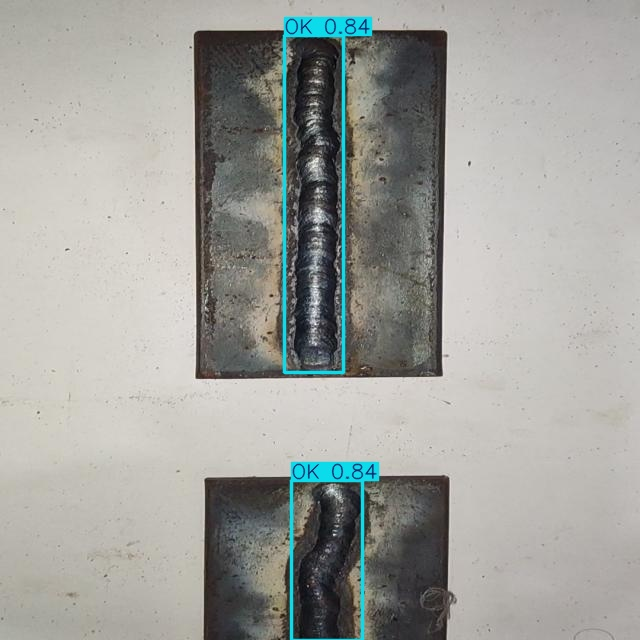


image 1/1 /home/roman/PycharmProjects/scientificProject_weldingFailerDetection_BlaasRoman/data/The Welding Defect Dataset/test/images/bad_weld_vid277_jpeg_jpg.rf.0e6aafa2605c842edfaedaba06ded02c.jpg: 640x640 1 NOK, 1 OK, 9.7ms
Speed: 0.8ms preprocess, 9.7ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


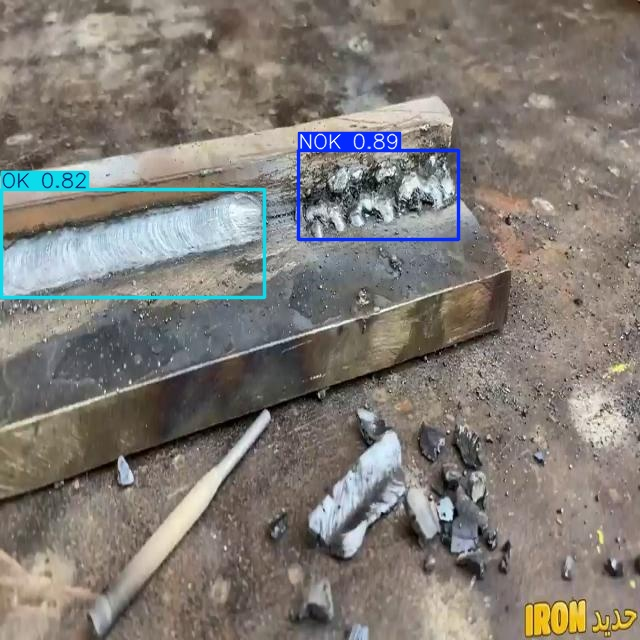


image 1/1 /home/roman/PycharmProjects/scientificProject_weldingFailerDetection_BlaasRoman/data/The Welding Defect Dataset/test/images/SampleV2_2_mp4-76_jpg.rf.492360f34b458a190c41d157fff3dbba.jpg: 640x640 1 OK, 8.5ms
Speed: 1.1ms preprocess, 8.5ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


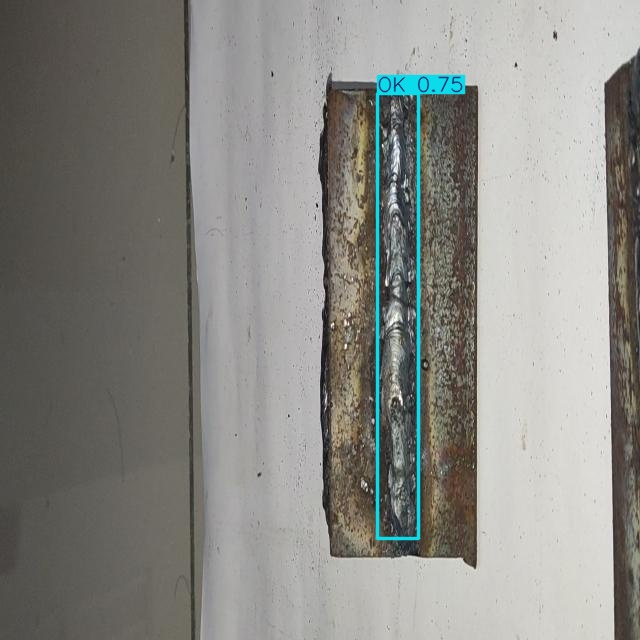


image 1/1 /home/roman/PycharmProjects/scientificProject_weldingFailerDetection_BlaasRoman/data/The Welding Defect Dataset/test/images/bad_weld_vid261_jpeg_jpg.rf.5ae3866fd5de7b144659fa7f7b92c5ba.jpg: 640x640 1 NOK, 2 OKs, 8.5ms
Speed: 0.9ms preprocess, 8.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


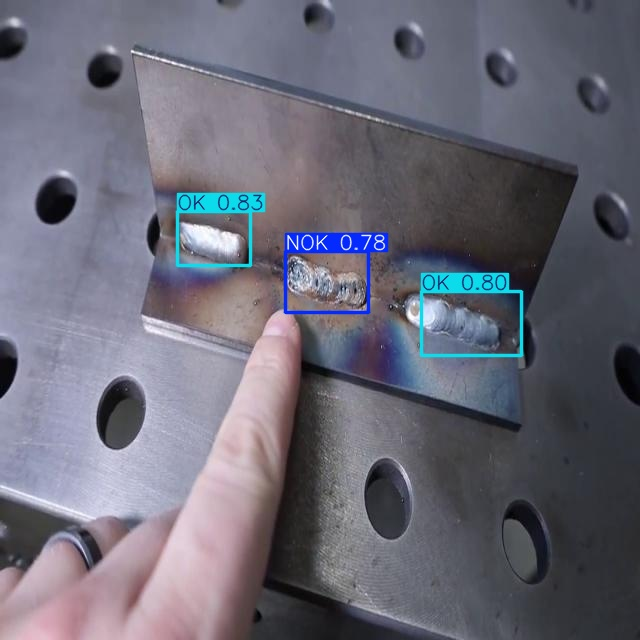


image 1/1 /home/roman/PycharmProjects/scientificProject_weldingFailerDetection_BlaasRoman/data/The Welding Defect Dataset/test/images/porosity-worm-hole-weld-defect-welding-process-flux-cored-arc-fcaw-204492534_jpeg_jpg.rf.c5201d1c888e3ffa1fded39930503d32.jpg: 640x640 1 NOK, 2 Defects, 8.5ms
Speed: 1.2ms preprocess, 8.5ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


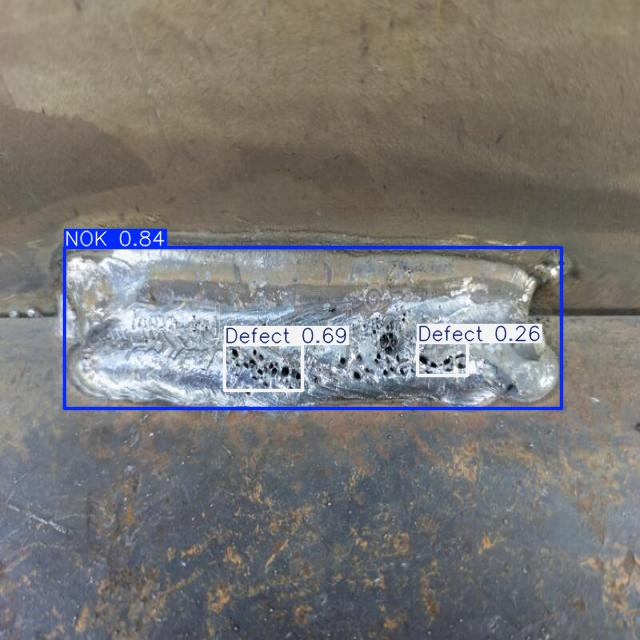


image 1/1 /home/roman/PycharmProjects/scientificProject_weldingFailerDetection_BlaasRoman/data/The Welding Defect Dataset/test/images/Good-Welding-images_17_jpeg_jpg.rf.be58c70a9f7f542fc89cb48847776741.jpg: 640x640 1 NOK, 2 OKs, 8.5ms
Speed: 0.9ms preprocess, 8.5ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


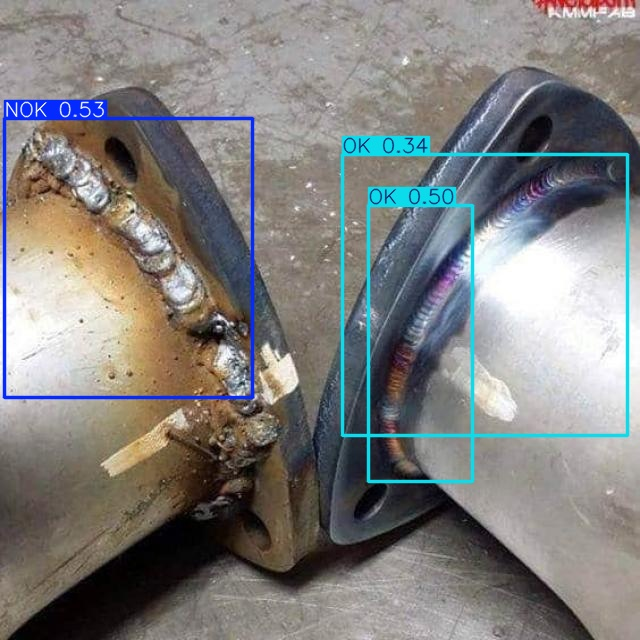


image 1/1 /home/roman/PycharmProjects/scientificProject_weldingFailerDetection_BlaasRoman/data/The Welding Defect Dataset/test/images/Screenshot-2022-12-05-230257_jpeg_jpg.rf.b7d7eb8e010e48641638d6a878f9af61.jpg: 640x640 1 NOK, 8.6ms
Speed: 1.2ms preprocess, 8.6ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


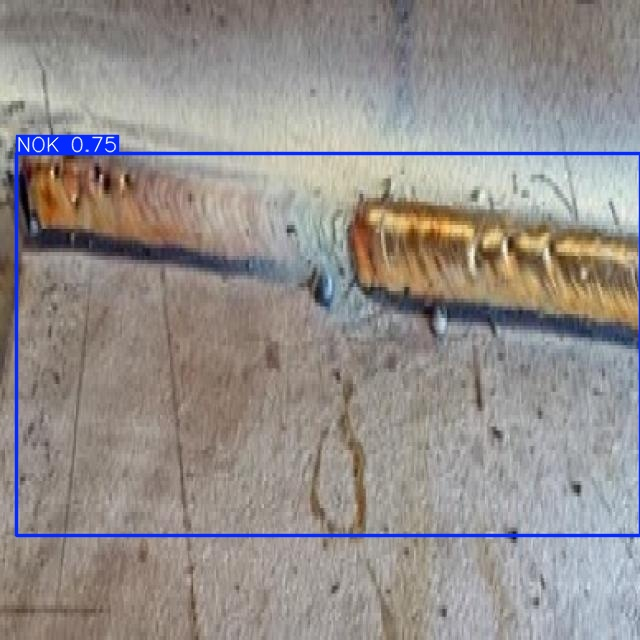

In [11]:
def display_results(model, img_dir, num_images=15, conf_threshold=0.3):
    
    images = os.listdir(img_dir)
    random.seed(time.time())
    sample_images = random.sample(images, num_images)
    
    save_dir = f'runs/detect/exp_{model_name}{value}_{time.strftime("%Y%m%d-%H%M%S")}'
    os.makedirs(save_dir, exist_ok=True)
    
    for image_name in sample_images:
        image_path = os.path.join(img_dir, image_name)
        results = model(image_path) #conf=conf_threshold
        
        for result in results:
            result.plot(save=True, filename=os.path.join(save_dir, os.path.basename(result.path)))
            
            result_image_path = os.path.join(save_dir, os.path.basename(result.path))
            display(Image(filename=result_image_path))

print()
print("Displaying results from test data")
print()

display_results(model, os.path.join(v2_dir, 'test/images'))